# DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project

Location of this project: https://github.com/NikoKuu/unsupervised-algorithms-in-ml-final

## Project Topic ##
This work is the final project for DTSA 5510 Unsupervised Algorithms in Machine Learning course. The objective is to demonstrate how to use unsupervised learning methods, including data cleaning and eploratory data analysis (EDA). 

A dataset of Amazon webstore item descriptions was selected from Kaggle by Pavlo Mospan.

Amazon Advertisements, Pavlo Mospan 2019. Available at: https://www.kaggle.com/datasets/sachsene/amazons-advertisements/data. 

The plan is to clean up the data, vectorize the text descriptions of each item and use unsupervised learning methods to categorize the data. The actual categories of each item are known so supervised learning methods can also be used as a comparison to unsupervised.  


## Data ##
The data set consists of 525 csv-files in different levels of categories, totaling more than three million items with description. There are about 20 main categories and up to two additional nested categories. The main focus of this work is to cluster the items based on the description text mainly focusing on the main category. 

Some of the text descriptions are very short and frankly impossible to categorize, such as a one-word text of the product part number. The text data also has a lot of numerical values for product dimensions or package quantity. A few methods to handle the numerical values were experimented. 

## Data Cleaning ##

#### Load most of the required modules

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, roc_auc_score
%matplotlib inline

#### Collect data

Accuracy measurement will be conducted to verify the performance of the model(s). However, the large number of main categories (over 20) makes label permutation to find optimal labels infeasible. 

$permutations = \frac{n!}{(n-r)!}$, where n is the total number of elements and r is the number of elements chosen.

In this case, $n=r$, and if we have $n=20$, we would have $20!\approx2.43e18$ permutations.

The number of main categories is thus reduced by making the following changes and corrections:
* Combine boys', girls', men's and women's fashion into one main category: fashion.
    * Boys', girls', men's and women's will be a sublabel.
* Move items in "home kitchen" category to main category "home" and subcategory "kitchen".
    * There already were some items in the home/kitchen -category.
* Move items in main category industrial/scientific category to common main category "industrial scientific".
    * There already were items in the "industrial scientific" -category.
* "Computers" moved under "electronics" main category
* "Smart home" moved under "electronics" main category
* Fix typo in 'sports'
    * No effect on the categories

With the modifications mentioned above, the number of main categories is down to 14 and number of permutations is $14!\approx8.7e10$.

In [ ]:
class amz_data:
    def __init__(self):
        self.id = 0
        self.df = pd.DataFrame()
        self.df_cat = pd.DataFrame(columns=['full', 'main', 'sub', 'subsub', 'bottom'])
        self.placeholder = ''#'<NUM>'

    def read_data(self, basedir):
         # https://docs.python.org/3.9/library/os.html?highlight=os%20walk
        for root, dirs, files in os.walk(basedir):
            #print(files)
            for file in files:
                path = os.path.join(root, file)
                self.add_to_dataframe(path)

    def add_to_dataframe(self, path):
        # print(path)
        # Too long path name. Needed to add the prefix for long path names.
        with open(u'\\\\?\\' + os.path.abspath(path), 'r', encoding="utf8") as f:
            # lines = f.readlines()
            lines = f.read().splitlines() # without the \n in the end 
        df = pd.DataFrame(lines[1:], columns=['description'])
        df['id'] = self.id # Assign a unique id
        df['word_count'] = df.apply(self.count_words, axis=1)
        df['description'] = df.apply(self.preprocess_text, axis=1)
        categories = list(self.get_category(os.path.basename(path)))
        df['full'] = categories[0]
        df['main'] =  categories[1]
        df['sub'] =  categories[2]
        df['subsub'] =  categories[3]
        df['bottom'] =  categories[4]
        self.df = pd.concat([self.df, df], ignore_index=True)
        # self.df_cat = pd.concat([self.df_cat, [self.id, self.get_category(os.path.basename(path))]], ignore_index=True)
        self.df_cat.loc[len(self.df_cat)] = list(categories)
        self.id = self.id + 1
    
    def get_category(self, file_name):
        if 'home-kitchen' in file_name: # Home kitchen -exception
            file_name = file_name.replace('home-kitchen', 'home_kitchen')
        if 'industrial_scientific' in file_name: # Industrial scientific -exception
            file_name = file_name.replace('industrial_scientific-tests-measurements', 'industrial_scientific_tests-measurements')
            file_name = file_name.replace('industrial_scientific', 'industrial-scientific')
        if '_computers' in file_name: # Computers -exception
            file_name = file_name.replace('_computers', '_electronics_computers')
        if '_smart-home' in file_name: # Smart home -exception
            file_name = file_name.replace('_smart-home', '_electronics_smart-home')
        if 'fan-shop' in file_name: # Fan shop -correction
            file_name = file_name.replace('fan-shop', 'sports-outdoors_fan-shop')
        if 'aports' in file_name: # aports -correction
            file_name = file_name.replace('aports', 'sports')
        category = file_name.split('.')[0]
        cat_list = category.split('_')
        
        if 'fashion' in cat_list[1]: # Fashion -exception
            cat_list.insert(2,cat_list[1].split('-')[0])
            cat_list[1] = 'fashion'
        cat_list = [s.replace('-', ' ') for s in cat_list]
        
        main = cat_list[1]
        if len(cat_list) >= 4:
            sub = cat_list[2]
        else:
            sub = None
        if len(cat_list) >= 5:
            subsub = cat_list[3]
        else: 
            subsub = None
        bottom = cat_list[-1]
        return category.replace('amazon_',''), main, sub, subsub, bottom
    
    def count_words(self, row):
        words = len(row['description'].split(' '))
        return words
    
    def replace_numbers(self, row):
        text = re.sub(r'\d+', self.placeholder, row['description'])
        return text
    
    def preprocess_text(self, row):
        text = row['description']
        text = text.lower().replace('mm','')
        text = text.replace('inches','')
        text = text.replace('inch','')
        text = text.replace('pack','')
        translator = str.maketrans('', '', string.punctuation + string.digits)
        return text.translate(translator)


# datafile = r'..\Datasets\Amazon Advertisements\scrapped_data\arts_crafts\amazon_arts_crafts_common.csv'
# df = pd.read_csv(datafile)

amz = amz_data()
amz.read_data(r'..\Amazon Ads\data')




### Dataset info ###

General info and five first entries are printed out below. 

The dataframe has over three million rows. However, it was found out that there are over 300,000 duplicated entries, and those were removed. 

In [ ]:
print(amz.df.info(),'\n')
print(amz.df.head(4),'\n')
print(amz.df.tail(4),'\n')
print('\nNumber of nan values:\n', np.sum(amz.df.isna())),'\n'
print('\nNumber of duplicated entries:', np.sum(amz.df.duplicated()))
print('Drop duplicates')
amz.df.drop_duplicates(inplace=True)
print('Number of duplicated entries:', np.sum(amz.df.duplicated()))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318260 entries, 0 to 3318259
Data columns (total 8 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   description  object
 1   id           int64 
 2   word_count   int64 
 3   full         object
 4   main         object
 5   sub          object
 6   subsub       object
 7   bottom       object
dtypes: int64(2), object(6)
memory usage: 202.5+ MB
None 

                                         description  id  word_count  \
0               hisense  k ultra hd smart led tv he    0          10   
1                vizio   k ultra hd smart led tv pe    0          11   
2        sony xbrxeseries class hdr uhd smart led tv   0           8   
3  tivo bolt vox tb dvr  streaming media player k...   0          17   

                     full         main   sub subsub      bottom  
0  electronics_smart-home  electronics  None   None  smart home  
1  electronics_smart-home  electronics  None   None  smart home  
2  electronics_smart

C:\Users\nikok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)



Number of nan values:
 description          0
id                   0
word_count           0
full                 0
main                 0
sub             925858
subsub         1933084
bottom               0
dtype: int64

Number of duplicated entries: 348496
Drop duplicates
Number of duplicated entries: 0


Total of 439 item level categories were found and those are grouped into 14 main categories.

In [ ]:
print(amz.df_cat.info(), '\n')
print('Duplicated entries:', np.any(amz.df_cat.duplicated()), '\n')
print('Number of full categories:', len(pd.unique(amz.df_cat['full'])))
print('Number of main categories:', len(pd.unique(amz.df_cat['main'])))
print('Number of sub-categories:', len(pd.unique(amz.df_cat['sub'])))
print('Number of lower sub-categories:', len(pd.unique(amz.df_cat['subsub'])))
print('Number of most detailed categories:', len(pd.unique(amz.df_cat['bottom'])))

<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 524
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   full    525 non-null    object
 1   main    525 non-null    object
 2   sub     395 non-null    object
 3   subsub  211 non-null    object
 4   bottom  525 non-null    object
dtypes: object(5)
memory usage: 24.6+ KB
None 

Duplicated entries: False 

Number of full categories: 525
Number of main categories: 14
Number of sub-categories: 25
Number of lower sub-categories: 18
Number of most detailed categories: 439


## Exploratory Data Analysis ##

Below a histogram of approximate word counts are plotted. The distribution looks reasonable. 

Also the shortest and the longest desriptions are found showing that the shortest has only one word and the longest has 186 words in them. 

Lastly, the box plot shows how many words each main category has. There does not seem to be significant difference in the description length between the main categories.  

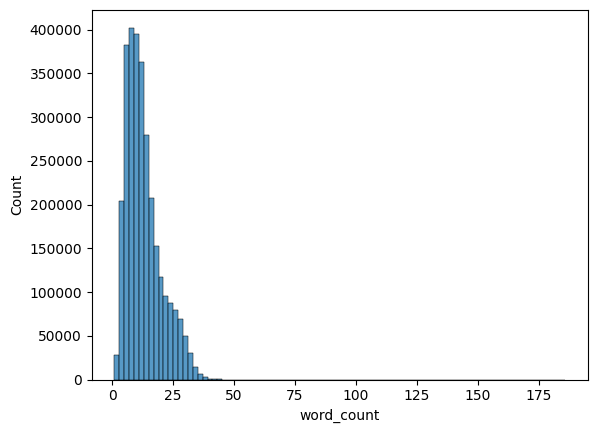

Maximum number of words: 186
Minimum number of words: 1
Entry with the minimum amount of words:
 description                   bxppwjz
id                                  0
word_count                          1
full           electronics_smart-home
main                      electronics
sub                              None
subsub                           None
bottom                     smart home
Name: 799, dtype: object


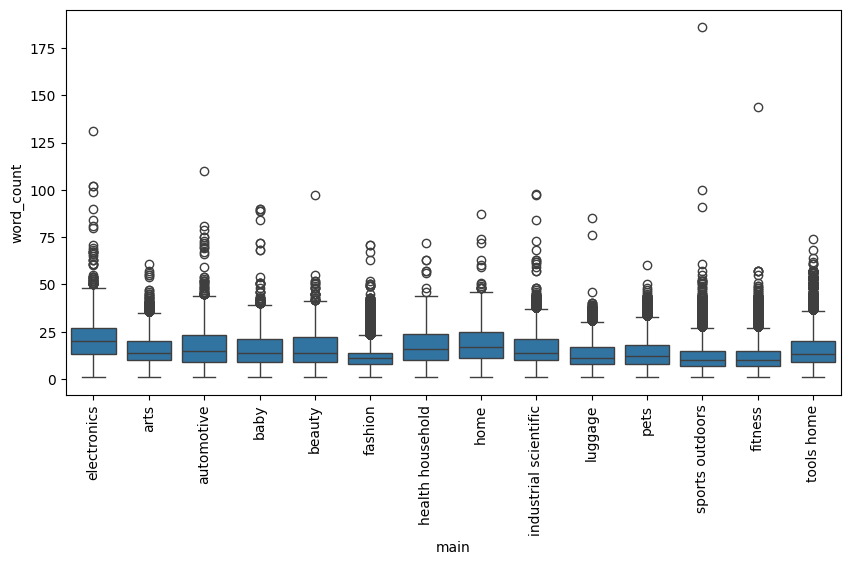

In [ ]:
sns.histplot(amz.df, x='word_count', binwidth=2)
plt.show()
print('Maximum number of words:', max(amz.df['word_count']))
print('Minimum number of words:', min(amz.df['word_count']))
print('Entry with the minimum amount of words:\n', amz.df.iloc[np.argmin(amz.df['word_count'])])

fig = plt.figure(figsize=(10, 5))
sns.boxplot(amz.df, x='main', y='word_count')
plt.xticks(rotation=90, fontsize = 10) 
plt.show()


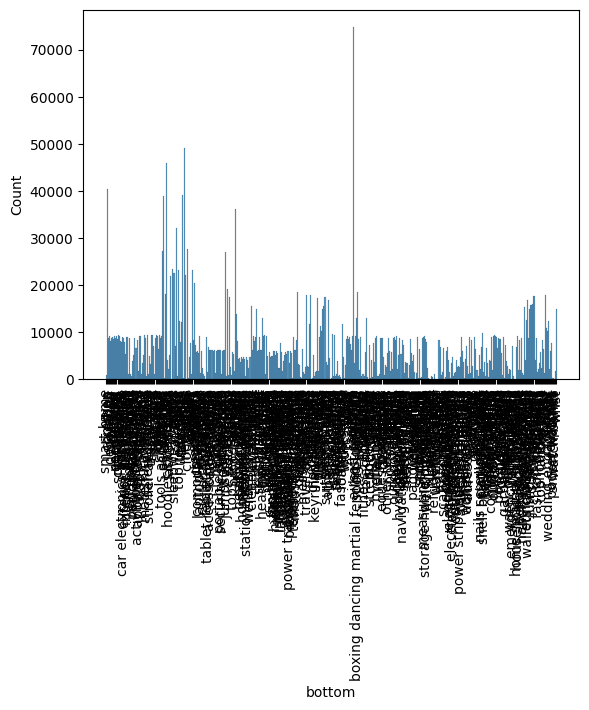

In [ ]:
sns.histplot(amz.df, x='bottom', binwidth=2)
plt.xticks(rotation=90, fontsize = 10) 
plt.show()

### Tokenization


Using TF-IDF to convert the text data to numerical representation in matrix format. 

Acronym TF-IDF comes from Term Frequency, Inverse Document Frequency. The first part, Term Frequency, tells how many times a certain word is found in the text. The second part, inverse of Document Frequency, divides the first part by how many documents contain the word. The division lowers the score for common words that appear often, like 'the', 'of', etc. 

Bag of words and TF-IDF should be good choices for the text in descriptions since they usually are just a list of keywords that do not necessary form meaningful sentences.

There are a few parameters to pay attention to. 

In [122]:
import random
number_of_categories = 7

main_category = True
mask = []
counts_train = []
if main_category:
    chosen_categories = random.sample(list(pd.unique(amz.df_cat['main'])), number_of_categories)
    for index, cat in enumerate(chosen_categories):
        m = amz.df['main'] == cat
        counts_train.append(sum(m))
        mask.append(m)
    amount = min(counts_train)
    idx_all = []
    for index, cat in enumerate(chosen_categories):
        m = amz.df['main'] == cat
        idx_all.append(np.where(m)[0][0:amount])
        
    idx_all = np.array(idx_all).flatten()
    X_train = amz.df['description'].iloc[idx_all]
    y_train = amz.df['main'].iloc[idx_all]
else:
    chosen_categories = amz.df_cat.sample(number_of_categories, random_state=334)
    for index, cat in chosen_categories.iterrows():
        m = amz.df['full'] == cat['full']
        counts_train.append(sum(m))
        mask.append(m)
    amount = min(counts_train)
    idx_all = []
    for index, cat in chosen_categories.iterrows():
        m = amz.df['full'] == cat['full']
        idx_all.append(np.where(m)[0][0:amount])

    idx_all = np.array(idx_all).flatten()
    X_train = amz.df['description'].iloc[idx_all]
    y_train = amz.df['full'].iloc[idx_all]

print(X_train.info())
print(y_train.info())
categories_train = pd.unique(y_train)
print('\n' + '\n'.join([cat+':'+str(cnt) for cat, cnt in zip(categories_train, counts_train)]))


<class 'pandas.core.series.Series'>
Index: 300615 entries, 335326 to 179533
Series name: description
Non-Null Count   Dtype 
--------------   ----- 
300615 non-null  object
dtypes: object(1)
memory usage: 4.6+ MB
None
<class 'pandas.core.series.Series'>
Index: 300615 entries, 335326 to 179533
Series name: main
Non-Null Count   Dtype 
--------------   ----- 
300615 non-null  object
dtypes: object(1)
memory usage: 4.6+ MB
None

beauty:69636
pets:67126
health household:42945
fashion:1099621
industrial scientific:145811
tools home:440287
automotive:101661


In [123]:
my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words="english", max_features=10000)
# my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words="english", max_features=10000)
# my_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words="english", max_features=10000)
# mat = my_vectorizer.fit_transform(amz.df['description'])
mat = my_vectorizer.fit_transform(X_train)
mat.shape


(300615, 10000)

In [124]:
print('Shape of the matrix:', mat.shape)
ftr_names = my_vectorizer.get_feature_names_out()
print('Length of ftr_names:',len(ftr_names))
print('ftr_names:', ftr_names[0:100])

Shape of the matrix: (300615, 10000)
Length of ftr_names: 10000
ftr_names: ['aa' 'aa aaa' 'aaa' 'aaa batteries' 'aal' 'ab' 'able' 'abn' 'abrasive'
 'abrasives' 'abrasivessait' 'abs' 'absolute' 'absorbency' 'absorbent'
 'absorber' 'absorbing' 'absorption' 'ac' 'ac dc' 'ac furnace'
 'ac voltage' 'accent' 'accents' 'access' 'access control' 'accessories'
 'accessories black' 'accessories women' 'accessory' 'accessory kit'
 'accord' 'accord civic' 'accuform' 'accuracy' 'accurate' 'accusize'
 'accusize industrial' 'acdc' 'acdelco' 'ace' 'acetal' 'acetylene' 'aches'
 'achilles' 'acid' 'acids' 'acne' 'acorn' 'acrylic' 'acrylic false'
 'acrylic gel' 'acrylic nail' 'acrylic nails' 'acrylic powder' 'acting'
 'action' 'activated' 'activated carbon' 'activated charcoal' 'active'
 'activities' 'activity' 'activity tracker' 'acupressure' 'acupuncture'
 'acura' 'acv' 'ad' 'adams' 'adapter' 'adapter car' 'adapters' 'adaptive'
 'adaptor' 'add' 'added' 'additional' 'additive' 'adds' 'adhesive'
 'adhesiv

## Models ##


### Helper functions ###

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, roc_auc_score

class calc_metrics:
    def __init__(self, y_test, y_pred):
        self.confusion_matrix = None
        self.recall = None
        self.f1_score = None
        self.precision = None
        self.recall = None
        self.FNR = None

        self.get_metrics(y_test, y_pred)

    def get_metrics(self, y_test, y_pred):
        conf_mat = confusion_matrix(y_test, y_pred)
        self.confusion_matrix = pd.DataFrame(conf_mat)
        self.accuracy = accuracy_score(y_test, y_pred)
        print('Accuracy:', round(self.accuracy, 3))
        print('Confusion matrix:')
        disp = ConfusionMatrixDisplay(conf_mat)
        disp.plot()
        plt.show()

In [126]:
# myNMF = NMF(n_components=number_of_categories, solver='cd', beta_loss='frobenius',alpha_W=0.0001, alpha_H='same')
# myNMF = NMF(n_components=number_of_categories, random_state=123, init='nndsvda', solver='mu', beta_loss="kullback-leibler", alpha_W=0.00005, alpha_H=0.00005, l1_ratio=0)
myNMF = NMF(n_components=number_of_categories)
W = myNMF.fit_transform(mat)
H = myNMF.components_

# W_test = myNMF.transform(X_test)
# print('Shape of W_test:', W_test.shape)

In [127]:
print('Shape of the matrix:', mat.shape)
print('Shape of W:', W.shape)
print('The first row of W:', W[0,:])
print('Shape of H:', H.shape)
print('The first column of H:', H[:,0])

Shape of the matrix: (300615, 10000)
Shape of W: (300615, 7)
The first row of W: [0.         0.00024339 0.00271115 0.03302413 0.         0.00047895
 0.00144811]
Shape of H: (7, 10000)
The first column of H: [0.00000000e+00 4.03497528e-02 8.06382213e-03 0.00000000e+00
 5.55274625e-05 0.00000000e+00 2.69721482e-03]


In [128]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

def plot_top_words(H, feature_names, n_top_words):
    for topic_idx, topic in enumerate(H):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        print(str(topic_idx) + ':', top_features)

print('Categories:\n' + '\n'.join(categories_train) + '\n')
plot_top_words(H, ftr_names, 10)


Categories:
beauty
pets
health household
fashion
industrial scientific
tools home
automotive

0: ['big boys' 'tshirt' 'shirt' 'tee' 'little' 'short sleeve' 'short' 'big'
 'sleeve' 'boys']
1: ['compatible' 'glasses' 'air' 'replacement' 'phone' 'mount' 'filter'
 'holder' 'black' 'car']
2: ['diable' 'equivalent' 'bulbs' 'base' 'watt' 'white' 'light bulb' 'led'
 'bulb' 'light']
3: ['ml' 'natural' 'ounce' 'conditioner' 'oil' 'shampoo' 'hair' 'fl oz' 'fl'
 'oz']
4: ['cage' 'toys' 'small' 'dogs' 'food' 'toy' 'bird' 'cat' 'pet' 'dog']
5: ['screw' 'head' 'metal' 'screws' 'pcs' 'set' 'door' 'stainless steel'
 'stainless' 'steel']
6: ['sticker' 'decals' 'manicure' 'stickers' 'pcs' 'wall' 'nail art' 'set'
 'art' 'nail']


yp length: 300615
2858  -  0.46518304143173164

Label order: 3 --> 6 --> 5 --> 0 --> 1 --> 4 --> 2

Accuracy: 0.4771


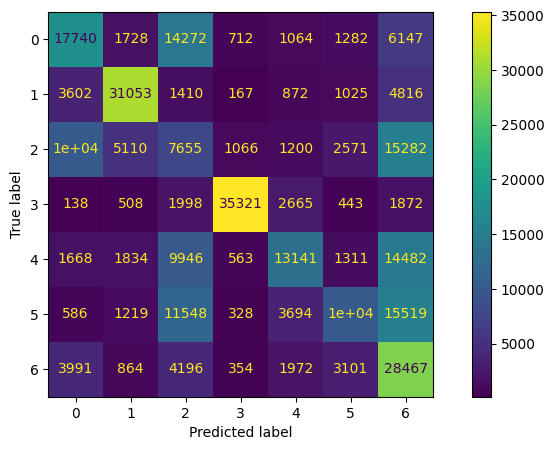

In [129]:
# The label_permute_compare -function below was adapted from my Week 2 peer review.

import itertools
from sklearn.metrics import ConfusionMatrixDisplay
import random


def label_permute_compare(ytdf,yp,portion=1):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    indices = random.sample(range(len(yp)), int(portion * len(yp)))
    labels = pd.unique(ytdf)
    acc = []
    best_accuracy = 0
    best_labelorder = []
    ypp = yp[indices]
    yt_indices = range(len(labels))
    # ytdf: from str to int
    labels_lst = list(labels)
    ytdfp = ytdf.iloc[indices]
    yt_vals = np.array([labels_lst.index(yt) for yt in list(ytdfp)])
    i = 0
    for labelorder in itertools.permutations(np.unique(yp)):
        # map_labels = [labels[mp] for mp in labelorder]
        # #print(map_labels)
        # yp_labels = [map_labels[yp[i]] for i in range(len(yp))]
        # acc.append(sum(ytdf==yp_labels)/len(yp_labels))
        # map_labels = [labels[mp] for mp in labelorder]
        # yp_labels = [map_labels[label] for label in ypp]
        # accuracy = sum(ytdfp == yp_labels) / len(yp_labels)

        yp_labels = [labelorder[y] for y in ypp]
        accuracy = sum(yt_vals == yp_labels)
        i=i+1
        if accuracy > best_accuracy:
            print(i, ' - ', best_accuracy / len(yp_labels), end='\r')
            best_accuracy = accuracy
            best_labelorder = labelorder
    print()
    best_accuracy = best_accuracy / len(yp_labels)
    return best_labelorder, best_accuracy
        # acc.append(accuracy)
    # i_max = np.argmax(acc)
    # return labelorders[i_max], acc[i_max]

def reorder_prediction(yp):
    # Remap the predicted labels
    ypp = [label_order[y] for y in yp]
    return ypp

yp = np.argmax(W,axis=1)
print('yp length:',len(yp))
label_order, best_accu = label_permute_compare(y_train, yp, 1)
print('\nLabel order:', ' --> '.join([str(lbl) for lbl in label_order]))
print('\nAccuracy:', round(best_accu,4))

ypp = reorder_prediction(yp)
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions([list(categories_train).index(yt) for yt in y_train], ypp, ax=ax)
plt.show()

# Yhat_train = [df_cat_mapper.iloc[i,0] for i in ypp]

Accuracy: 0.598


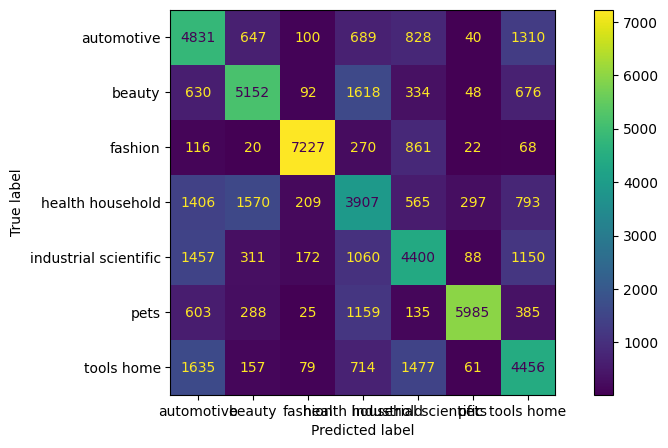

In [130]:
from sklearn.model_selection import train_test_split
from sklearn import svm

W_train_svm, W_test_svm, y_train_svm, y_test_svm = train_test_split(W, y_train, test_size=0.2)

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(W_train_svm, y_train_svm)
# print(W_train_svm.shape)
yhat_test_svm = clf.predict(W_test_svm)
print('Accuracy:', round(accuracy_score(y_test_svm, yhat_test_svm),3))

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test_svm, yhat_test_svm, ax=ax)
plt.show()

### K-Means

The number of clusters is known, 10 product categories selected. 

In [131]:
from sklearn.cluster import KMeans
my_kmeans = KMeans(n_clusters=number_of_categories, random_state=0, n_init="auto").fit(mat)
print('Values:', pd.unique(my_kmeans.labels_))
print('Length of labels:', len(my_kmeans.labels_))
print('Five first labels:', my_kmeans.labels_[0:6])


Values: [2 5 3 6 4 1 0]
Length of labels: 300615
Five first labels: [2 2 2 5 2 2]


1701  -  0.2663439948106382

Label order: 2 --> 3 --> 0 --> 6 --> 4 --> 1 --> 5

Accuracy: 0.2696


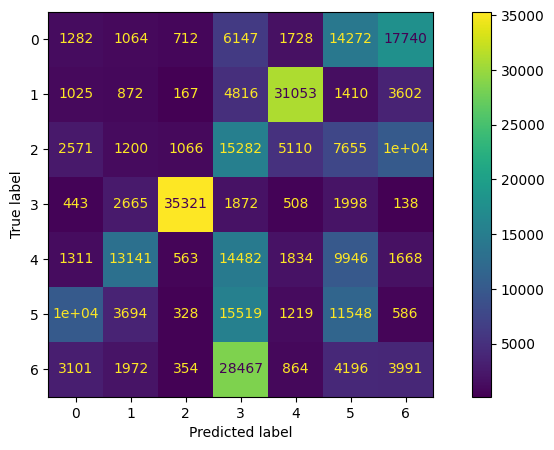

In [132]:
label_order, best_accu = label_permute_compare(y_train, my_kmeans.labels_, 1)
print('\nLabel order:', ' --> '.join([str(lbl) for lbl in label_order]))
print('\nAccuracy:', round(best_accu,4))

ypp = reorder_prediction(yp)
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions([list(categories_train).index(yt) for yt in y_train], ypp, ax=ax)
plt.show()

## Comparison with supervised methods

In [133]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

print('mat.shape:', mat.shape, '\nY_train.shape:', y_train.shape)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(mat, y_train, test_size=0.5, random_state=123)

mat.shape: (300615, 10000) 
Y_train.shape: (300615,)


In [89]:
from sklearn.svm import SVC

print('\nTry Radial Basis Function kernel:')
SVC_grid_paras = {'C':np.logspace(-5, 5, num=11 , base=2), 'gamma':np.logspace(-5, 5, num=11 , base=2)}
my_SVC_grid = GridSearchCV(estimator=SVC(), param_grid=SVC_grid_paras, scoring=None, n_jobs=None, refit=True, cv=5, verbose=0, pre_dispatch='2*n_jobs', return_train_score=True)
my_SVC_grid = my_SVC_grid.fit(X_train_clf, y_train_clf) # Create the model
print('Best parameters:', my_SVC_grid.best_params_)
print('Validation accuracy:', my_SVC_grid.best_score_)
my_SVC = my_SVC_grid.best_estimator_ # Save the best model
y_hat_SVC = my_SVC.predict(X_test_clf)
# calc_metrics(y_test_clf, y_hat_SVC) # calculate metrics


Try Radial Basis Function kernel:


KeyboardInterrupt: 

In [108]:
from sklearn.ensemble import RandomForestClassifier

RF_grid_paras = {'n_estimators': [10,100,500], 'min_samples_split': [2,3,4], 'min_samples_leaf': [1,2,3]}
my_RF_grid = GridSearchCV(RandomForestClassifier(), param_grid=RF_grid_paras, scoring=None, n_jobs=None, refit=True, cv=5, verbose=0, pre_dispatch='2*n_jobs', return_train_score=True)
my_RF_grid = my_RF_grid.fit(X_train_clf, y_train_clf) # Create the model
print('Best parameters:', my_RF_grid.best_params_)
print('Validation accuracy:', my_RF_grid.best_score_)
my_RF = my_RF_grid.best_estimator_ # Save the best model
y_hat_RF = my_RF.predict(X_test_clf)
# calc_metrics(y_test_clf, y_hat_SVC) # calculate metrics

KeyboardInterrupt: 

0.8920217154110227
Accuracy: 0.892
Confusion matrix:


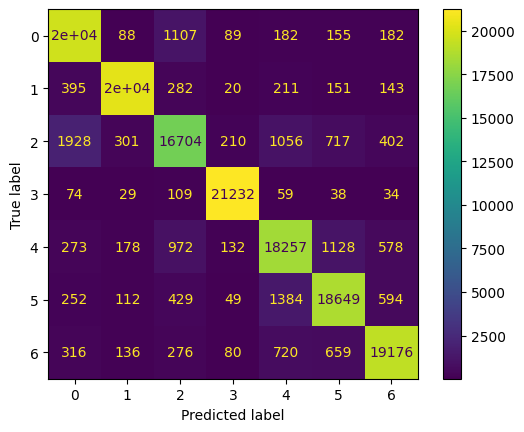

In [134]:
from sklearn.ensemble import RandomForestClassifier

my_RF = RandomForestClassifier().fit(X_train_clf, y_train_clf) # Create the model
y_hat_RF = my_RF.predict(X_test_clf)

print(accuracy_score(y_test_clf, y_hat_RF))

calc_metrics([list(categories_train).index(yt) for yt in y_test_clf], [list(categories_train).index(yt) for yt in y_hat_RF]) # calculate metrics


## Discussion and conclusion ##


### Training time ###


### Additional improvements

